# WikiTLDR 

A summarization/simplification dataset

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = sqlite3.connect('../raw_data/simple_en_wiki.db')
cursor = conn.cursor()

df = pd.read_sql_query("SELECT * FROM articles", conn)
df.drop(columns=['id'], inplace=True)
df.head()

,title,input_text,target_text
0,Johan August Arfwedson,Johan August Arfwedson (12 January 1792 – 28 O...,Johan August Arfwedson (12 January 1792 – 28 O...
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,..."
2,Moundou,Moundou (Arabic: موندو) is the second-largest ...,Moundou is the capital of the Logone Occidenta...
3,Kamrieng District,Kamrieng (Khmer: កំរៀង) is a district (srok) o...,Kamrieng District (Khmer: កំរៀង) is a district...
4,Mother 1 + 2,Mother (known as EarthBound outside Japan) is ...,Mother 1 + 2 is a video game for the Game Boy ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16295 entries, 0 to 16294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        16295 non-null  object
 1   input_text   16295 non-null  object
 2   target_text  16239 non-null  object
dtypes: object(3)
memory usage: 382.0+ KB


In [ ]:
df.isna().sum()

title           0
input_text      0
target_text    56
dtype: int64

We replace empty strings `""` with nulls. Because they *are* null values.

In [5]:
df.replace("", np.nan, inplace=True)

In [ ]:
df.isna().sum()

title           0
input_text      0
target_text    67
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.duplicated().sum()

824

In [9]:
df[df.duplicated()]

,title,input_text,target_text
1515,Mizrahi music,Mizrahi music (Hebrew: מוזיקה מזרחית muzika mi...,Mizrahi music (Hebrew: מוזיקה מזרחית) is a mus...
1683,Fantaisie-Impromptu,Frédéric Chopin's Fantaisie-Impromptu (Polish:...,Frédéric Chopin's Fantaisie-Impromptu in C♯ mi...
1769,"Stonewall County, Texas",Stonewall County is a county located in the U....,Stonewall County is a county in the U.S. state...
1844,Hanoi,Hanoi (Vietnamese: Hà Nội ) is the capital and...,Hanoi (Vietnamese: Hà Nội) is the capital of V...
1986,"Saint-Martin, Gers",Saint-Martin (French pronunciation: [sɛ̃ maʁtɛ...,Saint-Martin is a commune in the Gers departme...
...,...,...,...
16234,Third constituency for French residents overseas,The third constituency for French residents ov...,The third constituency for French residents ov...
16250,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."
16264,Pierre Gamarra,Pierre Gamarra (French pronunciation: [pjɛʁ ga...,"Pierre Gamarra (Toulouse, July 10, 1919 – Arge..."
16281,José Ramos-Horta,José Manuel Ramos-Horta GCL GColIH (Portuguese...,José Manuel Ramos-Horta GCL AC (Portuguese pro...


In [10]:
df[df["title"] == "Warangal"]

,title,input_text,target_text
3718,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."
16250,Warangal,Warangal () is a city in the Indian state of T...,"Warangal is a city in Telangana, India. It is ..."


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.info()
print("Null values: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 15404 entries, 0 to 16294
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        15404 non-null  object
 1   input_text   15404 non-null  object
 2   target_text  15404 non-null  object
dtypes: object(3)
memory usage: 481.4+ KB
Null values:  0
Duplicates:  0


Replace consecutive newlines `\n` with a single one.

In [13]:
print(df["input_text"].str.contains(r"\n{2,}", regex=True).sum())
print(df["target_text"].str.contains(r"\n{2,}", regex=True).sum())

4176
458


In [14]:
df["input_text"] = df["input_text"].str.replace(r"\n{2,}", "\n", regex=True)
df["target_text"] = df["target_text"].str.replace(r"\n{2,}", "\n", regex=True)

## Compression Ratio

This is the ratio of the length of the simplified text and the standard English text.

$$
\text{compression\_ratio} = \frac{\text{Length of simplified text}}{\text{Length of standard English text}}
$$

Larger compression ratio values mean larger summaries.

In [15]:
df["compression_ratio"] = df["target_text"].str.len() / df["input_text"].str.len()

In [16]:
df["compression_ratio"].describe()

count    15404.000000
mean         0.842184
std          1.267120
min          0.004037
25%          0.294284
50%          0.591273
75%          0.985289
max         67.228571
Name: compression_ratio, dtype: float64

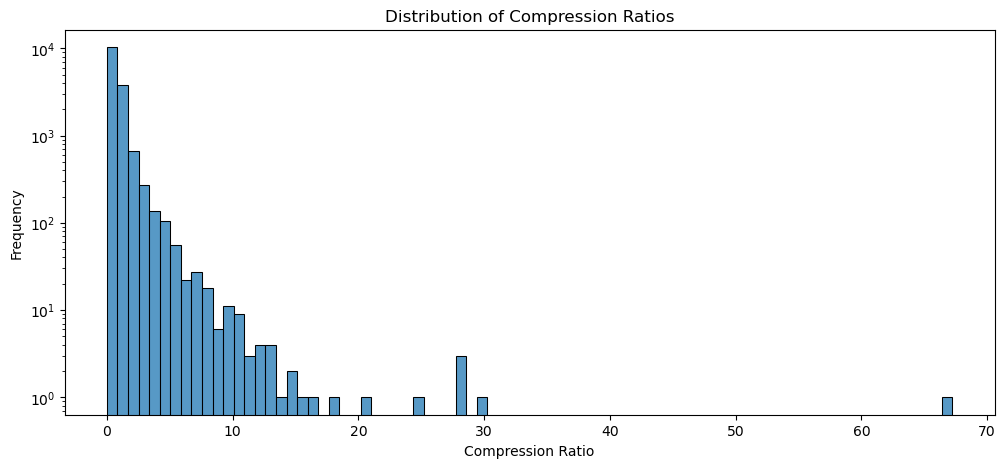

In [17]:
plt.figure(figsize=(12, 5))
sns.histplot(df['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [18]:
largest = df.iloc[np.argmax(df["compression_ratio"])]
print(largest)
print(largest["input_text"])
print()
print(largest["target_text"])

title                                         List of cities in Panama
input_text                         This is a list of cities in Panama.
target_text          This is a list of cities in Panama.\nAchutupo\...
compression_ratio                                            67.228571
Name: 5773, dtype: object
This is a list of cities in Panama.

This is a list of cities in Panama.
Achutupo
Agua Buena
Aguadulce, Coclé
Ailigandí
Alanje
Alcalde Díaz
Almirante, Bocas del Toro
Alto de la Estancia
Alto del Espino
Ancón, Panama
Antón
Arraiján
Aserrío de Gariché
Atalaya, Veraguas
Berbá
Bisira
Boca de Parita
Bocas Town, Bocas del Toro
Boquerón, Chiriquí
Boquete, Chiriquí
Bugaba
Burica
Bágala
Caimitillo
Calobre
Calzada Larga
Canoa
Capellanía
Capetí
Capira
Cartí Sugtupu
Cativá
Cañazas
Celmira
Cermeño
Cerro Cama
Cerro Punta, Chiriquí
Chame
Changuinola
Chepo
Chichica, Ngöbe-Buglé
Chigoré
Chiguirí Arriba
Chilibre
Chimán
Chiriquí Grande
Chitré, Herrera
Churuquita Chiquita
Churuquita Grande
Cirilo Guai

In [19]:
df.drop(index=np.argmax(df["compression_ratio"]), inplace=True)

In [20]:
df.head()

,title,input_text,target_text,compression_ratio
0,Johan August Arfwedson,Johan August Arfwedson (12 January 1792 – 28 O...,Johan August Arfwedson (12 January 1792 – 28 O...,0.862500
1,Kokarit frog,Humerana lateralis is a species of frog in the...,"The Kokarit frog, meng-yang frog, yellow frog,...",0.241987
2,Moundou,Moundou (Arabic: موندو) is the second-largest ...,Moundou is the capital of the Logone Occidenta...,0.617577
3,Kamrieng District,Kamrieng (Khmer: កំរៀង) is a district (srok) o...,Kamrieng District (Khmer: កំរៀង) is a district...,1.094737
4,Mother 1 + 2,Mother (known as EarthBound outside Japan) is ...,Mother 1 + 2 is a video game for the Game Boy ...,0.100660


In [21]:
df.drop(index=df[df["compression_ratio"] > 20].index, inplace=True)
df.reset_index(drop=True, inplace=True)

Articles titled "List of x things" on Wikipedia are not considered proper summarizations because they typically consist of enumerations rather than narrative content. These lists do not provide much context or detailed information to summarize.

In [22]:
df.drop(df[df["title"].str.contains("^List of", regex=True)].index, inplace=True)

In [23]:
large_summaries = df[df["compression_ratio"] > 1.5]

In [24]:
large_summaries.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio
8411,Moira Yip,Moira Yip (b. 1949) is a British-American ling...,Moira Yip is a British linguist. She earned he...,18.039216
1069,John Rodriguez,John Rodríguez may refer to:,"John R. Rodriguez (February 12, 1937 – July 5,...",16.275862
10033,Christoph Probst,Christoph Ananda Probst (6 November 1919 – 22 ...,"Christoph Probst (November 6, 1919-February 22...",15.130719
6117,Ramón Martínez,Ramon Martinez may refer to:,Ramón Martínez (31 August 1948 – 25 January 20...,14.857143
5276,Clarity (song),Clarity may refer to:,Clarity is a progressive house/electronic hous...,14.476190


In [25]:
len(large_summaries)

1594

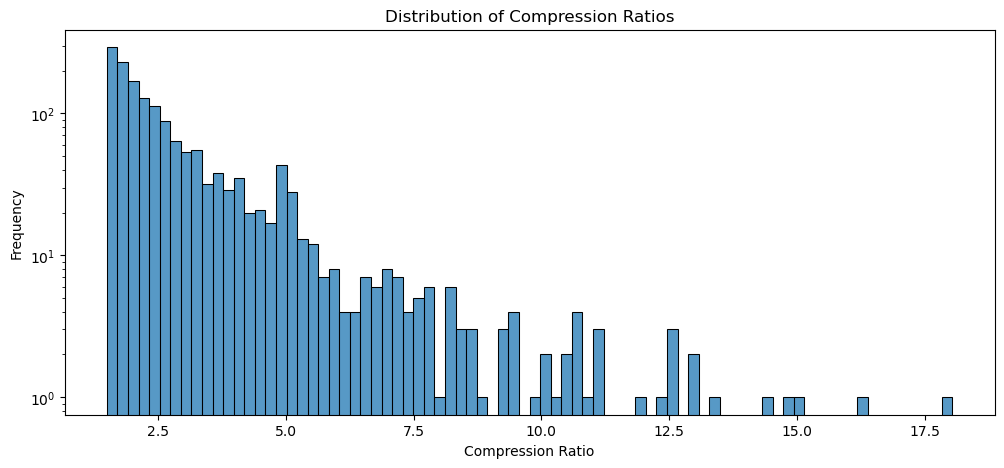

In [26]:
plt.figure(figsize=(12, 5))
sns.histplot(large_summaries['compression_ratio'], bins=80, log=True)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Compression Ratios')
plt.show()

In [27]:
sample = large_summaries.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([11179], dtype='int64')
Rapetosaurus ( rə-PAY-too-SOR-əs) is a genus of titanosaurian sauropod dinosaur that lived in Madagascar from 70 to 66 million years ago, at the end of the Cretaceous Period. Only one species, Rapetosaurus krausei, has been identified.
Like other sauropods, Rapetosaurus was a quadrupedal herbivore; it is calculated to have reached lengths of 15 metres (49 ft).
----------------------------------------Target Text----------------------------------------
Rapetosaurus is a genus of sauropod dinosaur. It lived in what is now Madagascar from 70 to 66 million years ago, at the end of the Cretaceous period. Only one species, Rapetosaurus krausei, has been found. Like other sauropods, Rapetosaurus was a quadrupedal herbivore.
The discovery of Rapetosaurus was the first time a titanosaur had been recovered with an almost perfectly intact skeleton, complete with skull. It has helped to clarify some difficult issues in this large group of sauropod dinosaurs. It provide

In [29]:
# minimum length thresholds
min_input_length = 50
min_target_length = 20

min_compression_ratio = 0.2
max_compression_ratio = 1.


filtered_df = df[
    (df['input_text'].str.len() >= min_input_length) &
    (df['target_text'].str.len() >= min_target_length) &
    (df['compression_ratio'] >= min_compression_ratio) &
    (df['compression_ratio'] <= max_compression_ratio)
]

filtered_df.sort_values("compression_ratio", ascending=False).head()

,title,input_text,target_text,compression_ratio
509,Minnie Pearl,"Sarah Ophelia Colley Cannon (October 25, 1912 ...","Sarah Ophelia Colley Cannon (October 25, 1912 ...",1.0
3743,Remetschwil,Remetschwil is a municipality in the district ...,Remetschwil is a municipality of the district ...,1.0
1569,Veena Sood,Veena Sood (born 21 November) is a Canadian ac...,"Veena Sood (born 21 November), is a Canadian a...",1.0
8233,Harpsichord,A harpsichord is a musical instrument played b...,Harpsichords are keyboard instruments that mak...,1.0
12954,Les Cassés,Les Cassés (French pronunciation: [le kase] ; ...,Les Cassés is a commune of 295 people (2017). ...,1.0


In [38]:
filtered_df.info()
print()
filtered_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9571 entries, 0 to 15395
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              9571 non-null   object 
 1   input_text         9571 non-null   object 
 2   target_text        9571 non-null   object 
 3   compression_ratio  9571 non-null   float64
dtypes: float64(1), object(3)
memory usage: 373.9+ KB



,compression_ratio
count,9571.000000
mean,0.558549
std,0.239236
min,0.200000
25%,0.346510
50%,0.529262
75%,0.757563
max,1.000000


In [45]:
sample = filtered_df.sample(1)
print(sample.index)
print(sample["input_text"].values[0])
print("-" * 40 + "Target Text" + "-" * 40)
print(sample["target_text"].values[0])

Index([92], dtype='int64')
Marcel Sabitzer (born 17 March 1994) is an Austrian professional footballer who plays as a midfielder for Bundesliga club Borussia Dortmund and captains the Austria national team. Predominantly a central midfielder, Sabitzer can play in a multitude of roles, including attacking midfielder, defensive midfielder, winger and second striker.
Sabitzer began his professional career in Austria with Admira Wacker and Rapid Wien. He joined German club RB Leipzig in 2014 and was immediately loaned to Red Bull Salzburg for a season. Sabitzer made more than 200 appearances for RB Leipzig, before Bayern Munich signed him in August 2021 for a reported transfer fee of €16 million.
Sabitzer represented Austria at multiple youth international levels and made his senior international debut at the age of 18 in June 2012. He has earned over 80 caps for Austria and played at the UEFA European Championship in 2016, 2020 and 2024.
----------------------------------------Target Text

In [ ]:
from textstat import textstat
from rouge import Rouge

# calculate readability score
filtered_df['readability_score'] = filtered_df['input_text'].apply(textstat.flesch_reading_ease)

# calculating ROUGE scores
rouge = Rouge()

def calculate_rouge(row):
    scores = rouge.get_scores(row['target_text'], row['input_text'])[0]
    return scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']

filtered_df[['rouge-1', 'rouge-2', 'rouge-l']] = filtered_df.apply(calculate_rouge, axis=1, result_type='expand')

filtered_df.head()

/tmp/ipykernel_21193/2186245230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['readability_score'] = filtered_df['input_text'].apply(textstat.flesch_reading_ease)
